# Research Question:
### What are the most influential variables on the severity of accidents?

In [1]:
#Display Spark Output in scrollable format within jupyter notebook
from IPython.core.display import HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

In [2]:
#Supress Warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Core libraries
import pandas as pd
import numpy as np

# PySpark imports
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.ml import Pipeline
import pyspark.sql.functions as F
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.stat import Correlation
from pyspark.ml.pipeline import PipelineModel
from pyspark.sql.functions import col

# Additional libraries for visualization and analysis
import matplotlib.pyplot as plt
import seaborn as sns

# Import Boost-specific modules for PySpark
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator,BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics, BinaryClassificationMetrics


# Load Data

In [4]:
spark = SparkSession.builder \
    .appName('GBoost-Traffic-Accidents') \
    .config("spark.executor.memory", "8g")\
    .config("spark.executor.cores", "1") \
    .config("spark.num.executors", "2") \
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")  # Suppress warnings

/opt/conda/lib/python3.7/site-packages/pyspark/bin/load-spark-env.sh: line 68: ps: command not found
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


24/12/04 16:21:23 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
# Read in Dataset
df = spark.read.parquet("final_dataset_binary.parquet")
df.show(5)

+-----------+--------+--------+----------+----------+-------------+-------+---------+----+----+-------------+--------------------------+--------------------+---------+-------------------+------------+-----------+--------------------+--------------------+-----------+---------------+-----------------+
|Temperature|Humidity|Pressure|Visibility|Wind_Speed|Precipitation|Weekday|Rush_Hour|Rain|Snow|    SeasonVec|Astronomical_TwilightIndex|Interstate_Indicator|Sex_ratio|Percent_Age_65_over|MedianIncome|Urban_Ratio|Traffic_Interference|Traffic_Intersection|Destination|Severity_Binary|Percent_Age_15-24|
+-----------+--------+--------+----------+----------+-------------+-------+---------+----+----+-------------+--------------------------+--------------------+---------+-------------------+------------+-----------+--------------------+--------------------+-----------+---------------+-----------------+
|         21|      85|      30|         1|        10|            0|      1|        1|   0|   1|(3

In [6]:
# Get row count
rows = df.count()
print(f"DataFrame Rows count : {rows}")

# Get columns count
cols = len(df.columns)
print(f"DataFrame Columns count : {cols}")

DataFrame Rows count : 7026806
DataFrame Columns count : 22


# Sampling

In [7]:
# Check Class Imbalance
cts = df.groupBy("Severity_Binary").count().withColumn('percent', (F.col('count') / rows)*100)
cts.show()

+---------------+-------+------------------+
|Severity_Binary|  count|           percent|
+---------------+-------+------------------+
|              1|1302620|18.537867702623352|
|              0|5724186| 81.46213229737664|
+---------------+-------+------------------+



In [8]:
class_counts = df.groupBy('Severity_Binary').count().collect()
total_count = df.count()

# Ensure that we have counts for both classes
class_weights = {}
for row in class_counts:
    class_weights[row['Severity_Binary']] = total_count / row['count']

print(f"Class Weights: {class_weights}")

Class Weights: {1: 5.39436366707098, 0: 1.2275642335870987}


In [9]:
df_with_weights = df.withColumn(
    'weight', 
    F.when(df['Severity_Binary'] == 1, class_weights[1])
     .when(df['Severity_Binary'] == 0, class_weights[0])
)

# Step 3: Drop rows with missing values in 'Severity_Binary' and 'weight' columns
df_with_weights = df_with_weights.dropna(subset=['Severity_Binary', 'weight'])

In [10]:
# Split into train, validation, and test sets (e.g., 60% train, 20% validation, 20% test)
train_df, val_df, test_df = df_with_weights.randomSplit([0.6, 0.2, 0.2], seed=42)

# Step 2: Get counts of each class in the training set
class_0_count = train_df.filter(train_df['Severity_Binary'] == 0).count()
class_1_count = train_df.filter(train_df['Severity_Binary'] == 1).count()

# Step 3: Downsample the majority class (class 0) to match the minority class (class 1) in the train set
class_0_sampled = train_df.filter(train_df['Severity_Binary'] == 0) \
    .sample(False, class_1_count / class_0_count, seed=42)

# For class 1 (minority class), no need to sample, keep all instances
class_1_df = train_df.filter(train_df['Severity_Binary'] == 1)

# Step 4: Combine the sampled data for the balanced training set
balanced_train_df = class_0_sampled.union(class_1_df)

# Check the class distribution in the balanced train set
train_class_counts_after = balanced_train_df.groupBy("Severity_Binary").count()
print("Train Class Counts (After Balancing):")
train_class_counts_after.show()

# Cache the balanced training set if needed
balanced_train_df.cache()

# Show the counts for validation, and test sets
val_class_counts = val_df.groupBy("Severity_Binary").count()
test_class_counts = test_df.groupBy("Severity_Binary").count()

# Show the counts for validation, and test sets
val_class_counts.show()
test_class_counts.show()


Train Class Counts (After Balancing):


+---------------+------+
|Severity_Binary| count|
+---------------+------+
|              0|783032|
|              1|782436|
+---------------+------+



+---------------+-------+
|Severity_Binary|  count|
+---------------+-------+
|              1| 260020|
|              0|1143161|
+---------------+-------+



+---------------+-------+
|Severity_Binary|  count|
+---------------+-------+
|              1| 260164|
|              0|1145306|
+---------------+-------+



# Modeling

In [11]:
feature_list = ['Temperature', 'Humidity', 'Pressure', 'Visibility', 'Wind_Speed',
                'Precipitation', 'Weekday', 'Rush_Hour', 'Rain', 'Snow', 'SeasonVec',
                'Astronomical_TwilightIndex', 'Interstate_Indicator', 'Sex_ratio',
                'Percent_Age_15-24', 'Percent_Age_65_over', 'MedianIncome',
                'Urban_Ratio', 'Traffic_Interference', 'Traffic_Intersection', 'Destination']

# Assemble the feature columns into a single vector column 'scaled_features'
assembler = VectorAssembler(inputCols=feature_list, outputCol='features')

In [12]:
gbt = GBTClassifier(labelCol="Severity_Binary", featuresCol="features")

# Step 4: Create a pipeline with the VectorAssembler and GBTClassifier
pipeline = Pipeline(stages=[assembler, gbt])

# Step 5: Handle missing values - Remove rows with missing values in the required columns
#df_with_weights = df_with_weights.dropna(subset=['Severity_Binary', 'weight'])
#df_with_weights.printSchema()

In [14]:
# Define the parameter grid
paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxIter, [3]) \
    .addGrid(gbt.maxDepth, [7]) \
    .build()

# Create a CrossValidator
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(labelCol="Severity_Binary"
                                                                      , predictionCol="prediction"
                                                                      , metricName="truePositiveRateByLabel"
                                                                      , metricLabel=1.0),
                          numFolds=5)

# Fit the model
cvModel = crossval.fit(balanced_train_df)

# Make predictions on the test set
predictions = cvModel.transform(val_df)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="Severity_Binary", predictionCol="prediction", metricName="truePositiveRateByLabel", metricLabel=1.0)
recall = evaluator.evaluate(predictions)
print("Recall: ", recall)

# Get and save the best model
bestModel = cvModel.bestModel
bestModel.save("best_gbt_model_v5")
print(bestModel.stages[-1]._java_obj.paramMap()) 

Recall:  0.6318898546265672
{
	GBTClassifier_00c70bbf7842-featuresCol: features,
	GBTClassifier_00c70bbf7842-labelCol: Severity_Binary,
	GBTClassifier_00c70bbf7842-maxDepth: 7,
	GBTClassifier_00c70bbf7842-maxIter: 3
}


In [15]:
loadedCvModel = PipelineModel.load("best_gbt_model_v5")

# Evaluation and Metrics

Weighted Precision: 0.7865326433678417
Weighted F1 Score: 0.7164733249034778
Accuracy: 0.6845759781425431


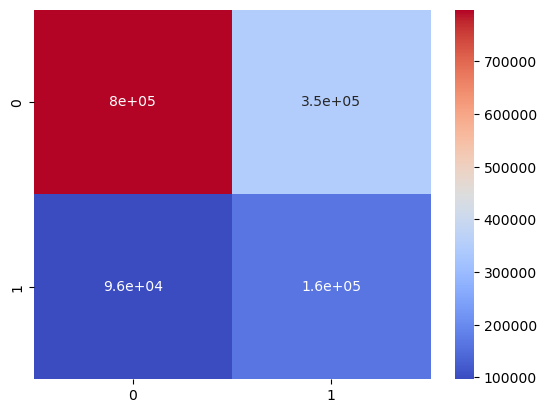

Area Under ROC: 0.6634089293493921


In [16]:
# Further Metrics on Best Model
pred = loadedCvModel.transform(test_df)

#Evaluate (Confusion Matrix, Accuracy, Weighted Precision, Recall, and F1 Score)
predictionAndLabels = pred.select("prediction", "Severity_Binary")
rdd = predictionAndLabels.rdd.map(lambda x: tuple(map(float, x)))
multi_metrics = MulticlassMetrics(rdd)

# Get precision, recall, and F1-score for each class
print(f'Weighted Precision: {multi_metrics.weightedPrecision}') #would expect to be good when test sample has high majority 0 class
#print(f'Weighted Recall: {multi_metrics.weightedRecall}')
print(f'Weighted F1 Score: {multi_metrics.weightedFMeasure()}') #would like to optimize this (balance of precision and recall)
print(f'Accuracy: {multi_metrics.accuracy}') #could be skewed with imbalanced test set

# Plot confusion matrix
cf = multi_metrics.confusionMatrix().toArray()
cf_df = pd.DataFrame(cf, columns=['0', '1'])
sns.heatmap(cf_df, annot=True, cmap="coolwarm")
plt.show()

# AUC Score
binary_metrics = BinaryClassificationMetrics(rdd)
auc = binary_metrics.areaUnderROC
print("Area Under ROC:", auc)

## Load Saved Best Model

## Feature Importance

In [17]:
feature_importances = cvModel.bestModel.stages[-1].featureImportances

# Create a mapping between feature names and their importance scores
feature_importance_dict = {}
feature_names = assembler.getInputCols()
for i, feature_name in enumerate(feature_names):
    feature_importance_dict[feature_name] = feature_importances[i]

# Sort the feature importance dictionary by score in descending order
sorted_feature_importances = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Print the feature importances
for feature_name, importance_score in sorted_feature_importances:
    print(f"{feature_name}: {importance_score}")

Percent_Age_15-24: 0.3807749047641967
Temperature: 0.09723874472631347
Wind_Speed: 0.0924156759505971
Pressure: 0.08509025538029755
Traffic_Intersection: 0.06838555971400324
SeasonVec: 0.044480192252258785
Astronomical_TwilightIndex: 0.034963359665166754
Urban_Ratio: 0.0317208838497207
Humidity: 0.024478388468449106
Traffic_Interference: 0.022646608718401472
Percent_Age_65_over: 0.015346639288703888
Interstate_Indicator: 0.015001347619558668
Sex_ratio: 0.00834292726125872
Destination: 0.006154785139735128
Weekday: 0.00560230439546761
MedianIncome: 0.005083259675392934
Rush_Hour: 0.003033902635665785
Visibility: 0.0022737969942266466
Rain: 0.002050753418427257
Snow: 0.00014633837406829439
Precipitation: 0.0


## Sensitivity

In [18]:
train_data_s = assembler.transform(balanced_train_df)
test_data_s = assembler.transform(test_df)

# Define parameter ranges
param_ranges = {
    "maxDepth": [3,4,5,6],
    "maxIter": [3,4,5,6]
}


# Create an evaluator
evaluator = MulticlassClassificationEvaluator(labelCol="Severity_Binary", predictionCol="prediction")

# Perform sensitivity analysis
results = []
for maxDepth in param_ranges["maxDepth"]:
    for maxIter in param_ranges["maxIter"]:
        # Create a model
        gbt = GBTClassifier(labelCol="Severity_Binary", featuresCol="features", maxDepth=maxDepth, maxIter=maxIter)

        # Fit the model
        model = gbt.fit(train_data_s)

        # Make predictions
        predictions = model.transform(test_data_s)

        # Evaluate the model
        recall = evaluator.evaluate(predictions, {evaluator.metricName:"truePositiveRateByLabel", evaluator.metricLabel: 1.0})
        f1 = evaluator.evaluate(predictions, {evaluator.metricName:"f1"})
        accuracy = evaluator.evaluate(predictions, {evaluator.metricName:"accuracy"})

        # Store the results
        results.append([maxDepth, maxIter, recall, f1, accuracy])

# Save and Print Results
sensitivity_analysis = pd.DataFrame(columns=['maxDepth', 'maxIter', 'recall', 'f1', 'accuracy'])
for i,result in enumerate(results):
    sensitivity_analysis.loc[i] = result
print(sensitivity_analysis)

    maxDepth  maxIter    recall        f1  accuracy
0        3.0      3.0  0.449889  0.761571  0.751711
1        3.0      4.0  0.467494  0.758773  0.746586
2        3.0      5.0  0.589597  0.716709  0.686298
3        3.0      6.0  0.589959  0.716581  0.686126
4        4.0      3.0  0.647641  0.686541  0.648397
5        4.0      4.0  0.643825  0.690822  0.653520
6        4.0      5.0  0.643533  0.691685  0.654547
7        4.0      6.0  0.624137  0.707064  0.673395
8        5.0      3.0  0.645535  0.691030  0.653732
9        5.0      4.0  0.640892  0.696955  0.660857
10       5.0      5.0  0.639516  0.699252  0.663624
11       5.0      6.0  0.629945  0.708110  0.674484
12       6.0      3.0  0.636302  0.707628  0.673724
13       6.0      4.0  0.632801  0.709788  0.676419
14       6.0      5.0  0.633189  0.710825  0.677656
15       6.0      6.0  0.627777  0.715467  0.683424
